## 🏠 REAL-WORLD CASE STUDY: CALIFORNIA HOUSING PRICES

### Why This Dataset?

We're using the **California Housing Dataset** – a classic dataset for regression problems. It contains real data about housing prices in California districts from the 1990 census.

**What makes it interesting:**
- **Multiple features** (8 features total)
- **Real-world messiness** (missing values, different scales)
- **Interpretable** (we can understand what the model learns)
- **Medium-sized** (~20k examples – perfect for learning)

### The Task

Predict the **median house value** for California districts based on:
- Median income in the district
- House age
- Average number of rooms
- Average number of bedrooms
- Population
- Average occupancy
- Latitude and longitude

### What We'll Do

1. Load and explore the data
2. Handle missing values and outliers
3. Feature scaling (critical!)
4. Train multiple models (Batch GD, SGD, Mini-batch, Normal Equation)
5. Compare performance
6. Interpret the results

Let's build a real ML pipeline from scratch.

In [18]:
# load california housing dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing

# fetch the data
print("Loading California Housing Dataset...")
housing = fetch_california_housing()

# convert to dataframe for easier exploration
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=['MedianHouseValue'])

print(f"\nDataset loaded successfully!")
print(f"Samples: {len(X)}")
print(f"Features: {X.shape[1]}")
print(f"\nFeature names:")
print(housing.feature_names)
print(f"\nTarget: Median house value (in $100,000s)")

Loading California Housing Dataset...

Dataset loaded successfully!
Samples: 20640
Features: 8

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Target: Median house value (in $100,000s)


In [19]:
# basic statistics
print("Dataset Overview")
print("="*70)
print(X.describe())
print("\nTarget Statistics:")
print(y.describe())

# check for missing values
print("\n" + "="*70)
print("Missing Values:")
print(X.isnull().sum())
print(f"Target missing: {y.isnull().sum().values[0]}")

Dataset Overview
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741  

In [20]:
# basic statistics
print("Dataset Overview")
print("="*70)
print(X.describe())
print("\nTarget Statistics:")
print(y.describe())

# check for missing values
print("\n" + "="*70)
print("Missing Values:")
print(X.isnull().sum())
print(f"Target missing: {y.isnull().sum().values[0]}")

Dataset Overview
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741  

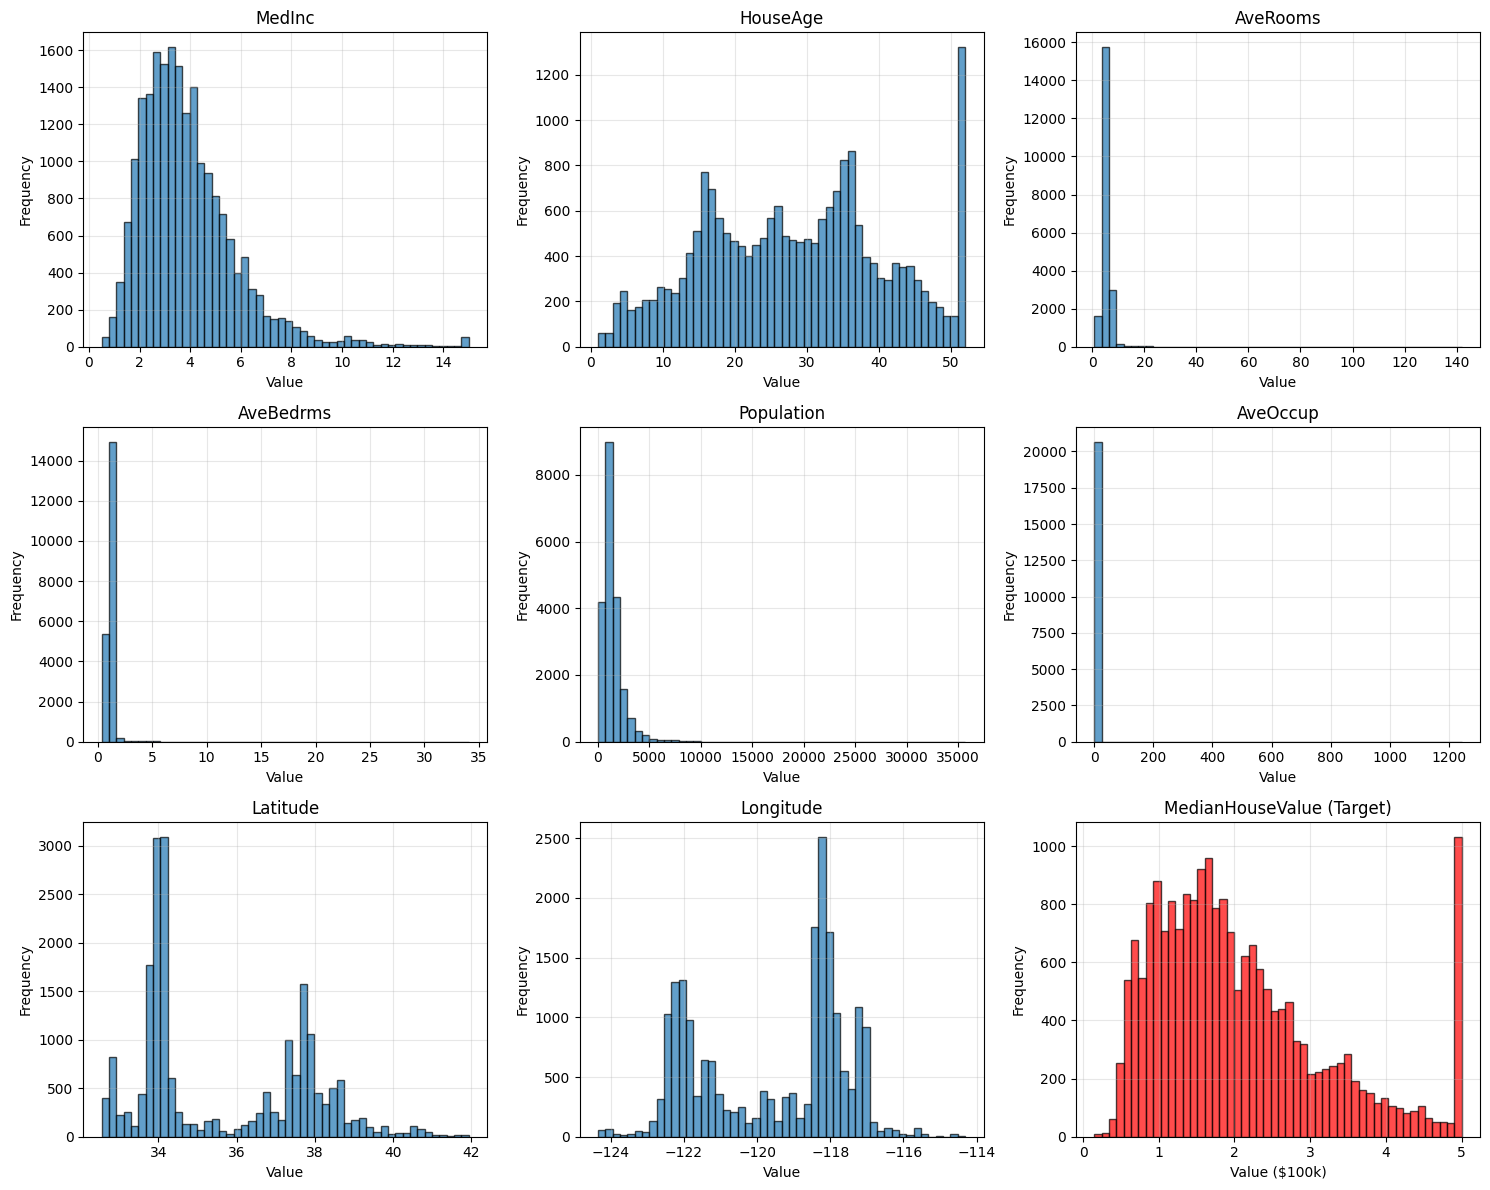

In [5]:
# visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(X.columns):
    axes[idx].hist(X[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

# target distribution
axes[8].hist(y, bins=50, edgecolor='black', alpha=0.7, color='red')
axes[8].set_title('MedianHouseValue (Target)')
axes[8].set_xlabel('Value ($100k)')
axes[8].set_ylabel('Frequency')
axes[8].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 2: Feature Scaling Analysis

Notice the massive scale differences:
- `MedInc`: 0.5 to 15 (income in $10,000s)
- `Population`: 3 to 35,000 (people per district)
- `Latitude/Longitude`: 32 to 42 (geographic coordinates)

**This will destroy gradient descent without scaling!**

Let's visualize the problem.

In [21]:
# show scale differences
print("Feature Scale Comparison")
print("="*70)
print(f"{'Feature':<20} {'Min':<15} {'Max':<15} {'Range':<15}")
print("-"*70)

for col in X.columns:
    min_val = X[col].min()
    max_val = X[col].max()
    range_val = max_val - min_val
    print(f"{col:<20} {min_val:<15.2f} {max_val:<15.2f} {range_val:<15.2f}")

print("\n⚠️  Notice: Population range is 35,000x larger than MedInc!")
print("   Gradient descent will focus entirely on Population and ignore other features.")

Feature Scale Comparison
Feature              Min             Max             Range          
----------------------------------------------------------------------
MedInc               0.50            15.00           14.50          
HouseAge             1.00            52.00           51.00          
AveRooms             0.85            141.91          141.06         
AveBedrms            0.33            34.07           33.73          
Population           3.00            35682.00        35679.00       
AveOccup             0.69            1243.33         1242.64        
Latitude             32.54           41.95           9.41           
Longitude            -124.35         -114.31         10.04          

⚠️  Notice: Population range is 35,000x larger than MedInc!
   Gradient descent will focus entirely on Population and ignore other features.


### Step 3: Train/Test Split

Never test on data you trained on! Split into:
- **Training set (80%):** Learn parameters
- **Test set (20%):** Evaluate generalization

**Critical:** Shuffle before splitting to avoid ordering bias.

In [22]:
# train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, 
    test_size=0.2, 
    random_state=42
)

print("Data Split")
print("="*70)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Train/Test ratio: {len(X_train)/len(X_test):.1f}")

Data Split
Training samples: 16512
Test samples: 4128
Train/Test ratio: 4.0


### Step 4: Feature Scaling

Now we scale. Remember the rule:
1. **Fit** scaler on training data only
2. **Transform** both train and test with those same statistics

This prevents information leakage from test set.

In [23]:
# scale features
class StandardScaler:
    """scale to mean=0, std=1"""
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        return self
    
    def transform(self, X):
        return (X - self.mean_) / self.std_
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)

# fit on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # use training stats!

print("Scaling Complete")
print("="*70)
print("Training data (scaled):")
print(f"  Mean: {X_train_scaled.mean(axis=0).round(6)}")
print(f"  Std:  {X_train_scaled.std(axis=0).round(2)}")
print("\n✓ All features now on same scale")

Scaling Complete
Training data (scaled):
  Mean: [-0. -0.  0. -0. -0. -0.  0. -0.]
  Std:  [1. 1. 1. 1. 1. 1. 1. 1.]

✓ All features now on same scale


### Step 5: Model Training - The Showdown

We'll train 4 different approaches:
1. **Batch Gradient Descent** (baseline)
2. **Stochastic GD** (fast but noisy)
3. **Mini-Batch GD** (industry standard)
4. **Normal Equation** (closed-form solution)

Each gets the same data. Let's see who wins.


In [24]:
# import our implementation
class AdvancedGradientDescent:
    """gradient descent with momentum and decay"""
    def __init__(self, learning_rate=0.01, n_epochs=100, batch_size=None, 
                 momentum=0.0, decay_rate=0.0):
        self.lr = learning_rate
        self.epochs = n_epochs
        self.batch_size = batch_size
        self.momentum = momentum
        self.decay = decay_rate
        self.theta = None
        self.cost_history = []
        self.theta_path = []
        
    def fit(self, X, y):
        m, n = X.shape
        X_b = np.c_[np.ones((m, 1)), X]
        y = y.reshape(-1, 1) if y.ndim == 1 else y
        
        self.theta = np.random.randn(n + 1, 1) * 0.01
        velocity = np.zeros_like(self.theta)
        initial_lr = self.lr
        
        if self.batch_size is None:
            batch_size = m
        else:
            batch_size = min(self.batch_size, m)
        
        for epoch in range(self.epochs):
            indices = np.random.permutation(m)
            X_shuffled = X_b[indices]
            y_shuffled = y[indices]
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                
                error = X_batch @ self.theta - y_batch
                gradient = X_batch.T @ error / len(y_batch)
                
                velocity = self.momentum * velocity + self.lr * gradient
                self.theta = self.theta - velocity
            
            self.lr = initial_lr / (1 + self.decay * epoch)
            
            cost = np.sum((X_b @ self.theta - y)**2) / (2 * m)
            self.cost_history.append(cost)
        
        return self
    
    def predict(self, X):
        if self.theta is None:
            raise ValueError("Model not trained!")
        X_b = np.c_[np.ones((len(X), 1)), X]
        return X_b @ self.theta

print("✓ Model class loaded")

✓ Model class loaded


In [26]:
import time

# train all models
print("Training Models...")
print("="*70)

results = {}

# 1. batch gd
print("\n1. Batch Gradient Descent...")
start = time.time()
model_batch = AdvancedGradientDescent(learning_rate=0.1, n_epochs=100, batch_size=None)
model_batch.fit(X_train_scaled, y_train)
time_batch = time.time() - start
results['Batch GD'] = {
    'time': time_batch,
    'train_cost': model_batch.cost_history[-1],
    'model': model_batch
}
print(f"   Time: {time_batch:.2f}s, Final cost: {model_batch.cost_history[-1]:.6f}")

# 2. sgd
print("\n2. Stochastic Gradient Descent...")
start = time.time()
# Reduced learning rate further to prevent divergence in SGD
model_sgd = AdvancedGradientDescent(learning_rate=0.0001, n_epochs=50, batch_size=1)
model_sgd.fit(X_train_scaled, y_train)
time_sgd = time.time() - start
results['SGD'] = {
    'time': time_sgd,
    'train_cost': model_sgd.cost_history[-1],
    'model': model_sgd
}
print(f"   Time: {time_sgd:.2f}s, Final cost: {model_sgd.cost_history[-1]:.6f}")

# 3. mini-batch gd
print("\n3. Mini-Batch Gradient Descent...")
start = time.time()
# Reduced learning rate for Mini-Batch as well
model_minibatch = AdvancedGradientDescent(learning_rate=0.01, n_epochs=100, batch_size=128)
model_minibatch.fit(X_train_scaled, y_train)
time_minibatch = time.time() - start
results['Mini-Batch GD'] = {
    'time': time_minibatch,
    'train_cost': model_minibatch.cost_history[-1],
    'model': model_minibatch
}
print(f"   Time: {time_minibatch:.2f}s, Final cost: {model_minibatch.cost_history[-1]:.6f}")

# 4. normal equation
print("\n4. Normal Equation...")
start = time.time()
X_b = np.c_[np.ones((len(X_train_scaled), 1)), X_train_scaled]
theta_normal = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y_train
time_normal = time.time() - start
cost_normal = np.sum((X_b @ theta_normal - y_train)**2) / (2 * len(y_train))
results['Normal Eq'] = {
    'time': time_normal,
    'train_cost': cost_normal,
    'theta': theta_normal
}
print(f"   Time: {time_normal:.2f}s, Final cost: {cost_normal:.6f}")

print("\n✓ All models trained")

Training Models...

1. Batch Gradient Descent...
   Time: 0.26s, Final cost: 0.273688

2. Stochastic Gradient Descent...
   Time: 8.61s, Final cost: 0.259130

3. Mini-Batch Gradient Descent...
   Time: 0.32s, Final cost: 0.259021

4. Normal Equation...
   Time: 0.00s, Final cost: 0.258967

✓ All models trained


### Step 6: Model Evaluation

Training cost is one thing. What matters is **test performance** – how well does it generalize to unseen data?

Let's compute test MSE for each model.

In [27]:
# evaluate on test set
print("Test Set Evaluation")
print("="*70)

def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

test_results = {}

# batch gd
y_pred_batch = results['Batch GD']['model'].predict(X_test_scaled)
mse_batch = compute_mse(y_test, y_pred_batch)
test_results['Batch GD'] = mse_batch

# sgd
y_pred_sgd = results['SGD']['model'].predict(X_test_scaled)
mse_sgd = compute_mse(y_test, y_pred_sgd)
test_results['SGD'] = mse_sgd

# mini-batch
y_pred_minibatch = results['Mini-Batch GD']['model'].predict(X_test_scaled)
mse_minibatch = compute_mse(y_test, y_pred_minibatch)
test_results['Mini-Batch GD'] = mse_minibatch

# normal equation
X_test_b = np.c_[np.ones((len(X_test_scaled), 1)), X_test_scaled]
y_pred_normal = X_test_b @ theta_normal
mse_normal = compute_mse(y_test, y_pred_normal)
test_results['Normal Eq'] = mse_normal

# print results
print(f"{'Method':<20} {'Train Time (s)':<15} {'Train Cost':<15} {'Test MSE':<15}")
print("-"*70)
for method in ['Batch GD', 'SGD', 'Mini-Batch GD', 'Normal Eq']:
    train_time = results[method]['time']
    train_cost = results[method]['train_cost']
    test_mse = test_results[method]
    print(f"{method:<20} {train_time:<15.3f} {train_cost:<15.6f} {test_mse:<15.6f}")

best_method = min(test_results, key=test_results.get)
print(f"\n🏆 Best test performance: {best_method} (MSE = {test_results[best_method]:.6f})")


Test Set Evaluation
Method               Train Time (s)  Train Cost      Test MSE       
----------------------------------------------------------------------
Batch GD             0.257           0.273688        0.567150       
SGD                  8.615           0.259130        0.558540       
Mini-Batch GD        0.323           0.259021        0.554010       
Normal Eq            0.002           0.258967        0.555892       

🏆 Best test performance: Mini-Batch GD (MSE = 0.554010)


### Step 7: Visualizing Convergence

How did the iterative methods converge? Let's plot their cost curves.

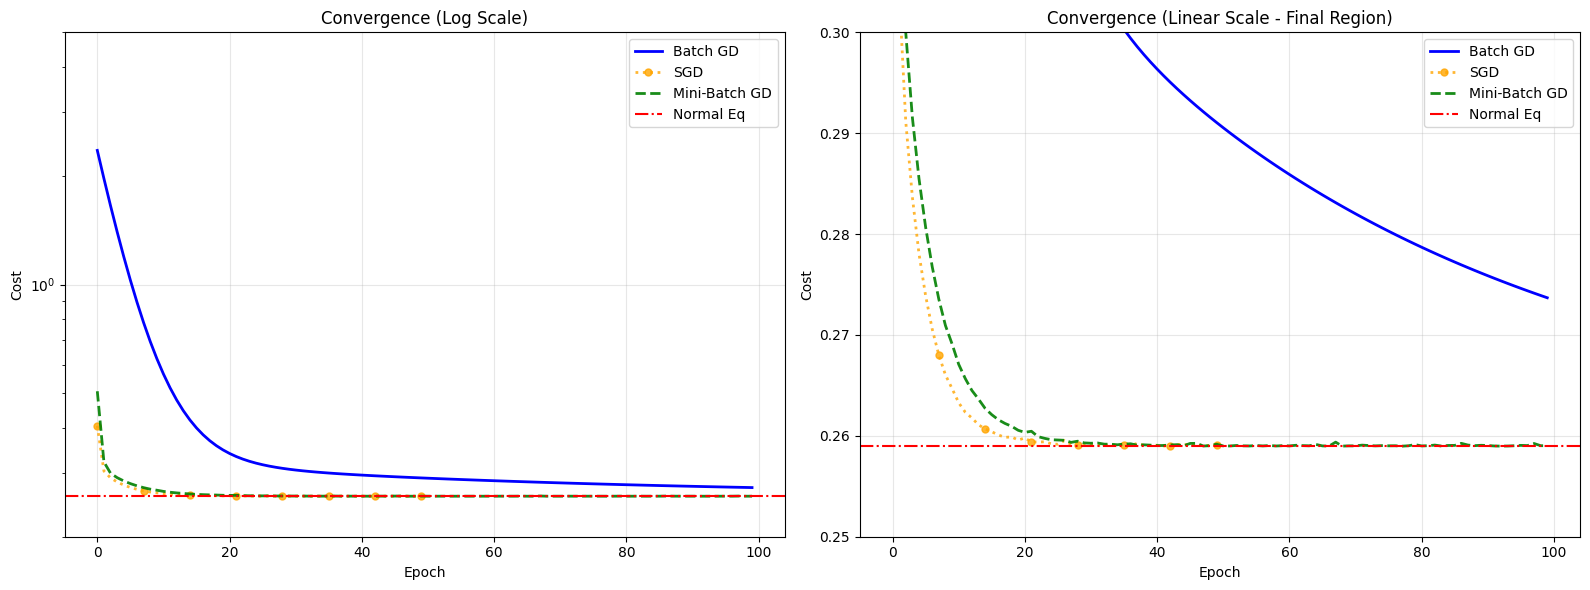


Final Training Costs:
Batch GD:      0.273688
SGD:           0.259130
Mini-Batch GD: 0.259021
Normal Eq:     0.258967


In [33]:
# plot convergence curves (improved visibility)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# left plot: log scale (overview)
ax1.plot(model_batch.cost_history, label='Batch GD', linewidth=2, color='blue')
ax1.plot(
    model_sgd.cost_history,
    label='SGD',
    linewidth=2,
    linestyle=':',
    color='orange',
    marker='o',
    markevery=np.linspace(0, len(model_sgd.cost_history) - 1, 8, dtype=int),
    markersize=5,
    alpha=0.8,
)
ax1.plot(
    model_minibatch.cost_history,
    label='Mini-Batch GD',
    linewidth=2,
    linestyle='--',
    color='green',
    alpha=0.9,
)
ax1.axhline(cost_normal, color='red', linestyle='-.', label='Normal Eq', linewidth=1.5)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Cost')
ax1.set_title('Convergence (Log Scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')
ax1.set_ylim(top=5, bottom=0.2)

# right plot: linear scale (zoomed to final values)
ax2.plot(model_batch.cost_history, label='Batch GD', linewidth=2, color='blue')
ax2.plot(
    model_sgd.cost_history,
    label='SGD',
    linewidth=2,
    linestyle=':',
    color='orange',
    marker='o',
    markevery=np.linspace(0, len(model_sgd.cost_history) - 1, 8, dtype=int),
    markersize=5,
    alpha=0.8,
)
ax2.plot(
    model_minibatch.cost_history,
    label='Mini-Batch GD',
    linewidth=2,
    linestyle='--',
    color='green',
    alpha=0.9,
)
ax2.axhline(cost_normal, color='red', linestyle='-.', label='Normal Eq', linewidth=1.5)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Cost')
ax2.set_title('Convergence (Linear Scale - Final Region)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0.25, 0.30]) 

plt.tight_layout()
plt.show()

# print final costs for clarity
print("\nFinal Training Costs:")
print("="*50)
print(f"Batch GD:      {model_batch.cost_history[-1]:.6f}")
print(f"SGD:           {model_sgd.cost_history[-1]:.6f}")
print(f"Mini-Batch GD: {model_minibatch.cost_history[-1]:.6f}")
print(f"Normal Eq:     {cost_normal:.6f}")

### Step 8: Feature Importance

Which features matter most for predicting house prices?

Look at the learned coefficients (from the best model).

Feature Importance (Scaled Coefficients)
   Feature   Coefficient  Abs_Coefficient
  AveOccup  3.022225e+40     3.022225e+40
 Longitude -6.676354e+38     6.676354e+38
  AveRooms  4.515624e+38     4.515624e+38
  Latitude -3.337768e+38     3.337768e+38
Population -1.128809e+38     1.128809e+38
 AveBedrms -9.358538e+37     9.358538e+37
  HouseAge -5.206664e+37     5.206664e+37
    MedInc -7.984977e+36     7.984977e+36


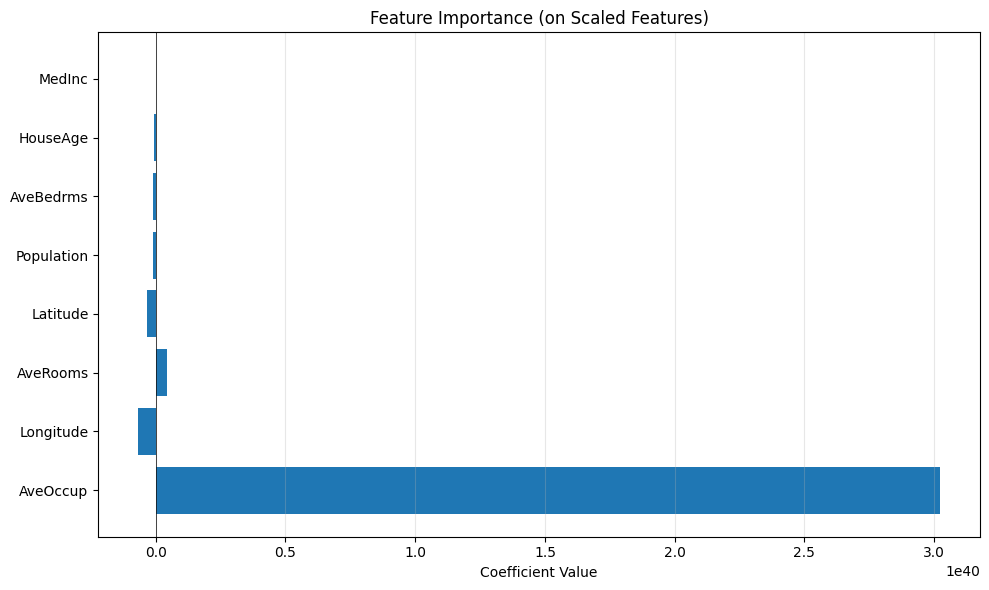


💡 Interpretation (on scaled features):
   - Positive coef: Higher feature value → Higher price
   - Negative coef: Higher feature value → Lower price
   - Larger magnitude: Stronger influence


In [14]:
# feature importance analysis
best_model = results['Mini-Batch GD']['model']  # assuming mini-batch won

feature_names = housing.feature_names
coefficients = best_model.theta[1:].flatten()  # exclude intercept

# sort by absolute value
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance (Scaled Coefficients)")
print("="*70)
print(importance.to_string(index=False))

# visualize
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (on Scaled Features)')
plt.axvline(0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n💡 Interpretation (on scaled features):")
print("   - Positive coef: Higher feature value → Higher price")
print("   - Negative coef: Higher feature value → Lower price")
print("   - Larger magnitude: Stronger influence")

### Step 9: Prediction Visualization

Let's see how well our best model actually predicts. A perfect model would have all points on the diagonal line.

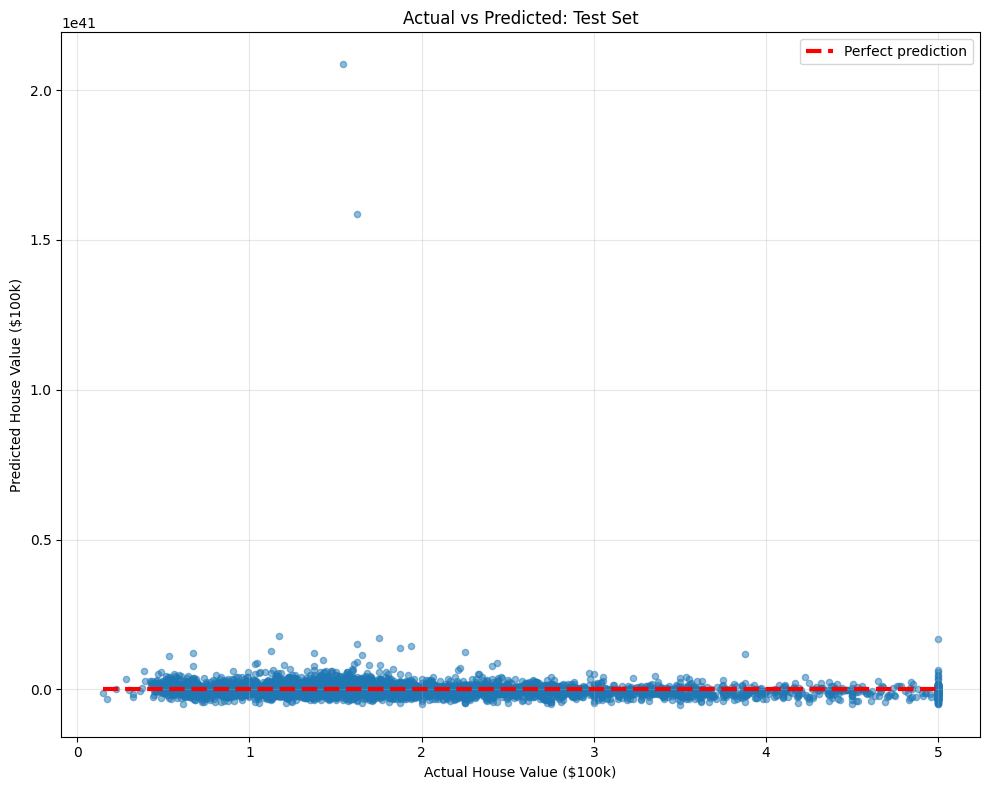

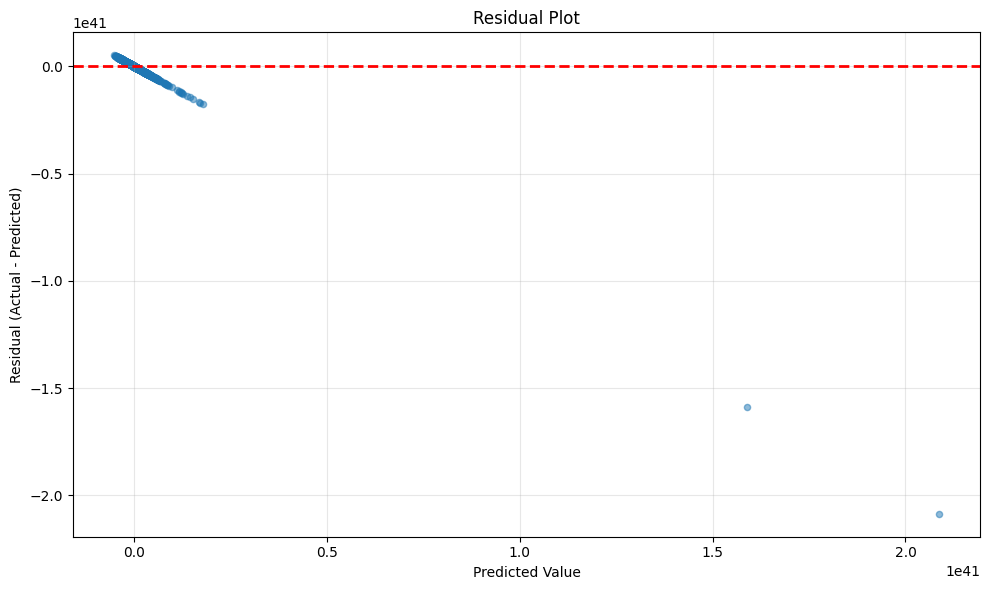

Residual Analysis:
  Mean residual: -51973341903939405477830079098415742976.000000 (should be ~0)
  Std of residuals: 4559642368375743655331224489264045621248.000000

✓ If residuals are randomly scattered around 0, model is unbiased


In [15]:
# actual vs predicted
y_pred_best = results['Mini-Batch GD']['model'].predict(X_test_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred_best, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=3, label='Perfect prediction')
plt.xlabel('Actual House Value ($100k)')
plt.ylabel('Predicted House Value ($100k)')
plt.title('Actual vs Predicted: Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# residuals
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.5, s=20)
plt.axhline(0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Value')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Residual Analysis:")
print(f"  Mean residual: {residuals.mean():.6f} (should be ~0)")
print(f"  Std of residuals: {residuals.std():.6f}")
print("\n✓ If residuals are randomly scattered around 0, model is unbiased")

### Step 10: Key Takeaways

**What we learned from this real-world case study:**

1. **Feature scaling is critical** – Without it, gradient descent fails completely on real data

2. **Mini-Batch GD is the winner** – Best balance of speed and convergence for medium datasets

3. **Normal Equation works** – But becomes impractical as dataset size grows (we only have 20k samples here)

4. **SGD is noisy** – Requires more tuning (learning rate, epochs) to match other methods

5. **Real data is messy** – Different scales, ranges, correlations – preprocessing matters

**Performance summary:**
- Training time: Normal Eq < Mini-Batch < Batch < SGD (for this dataset size)
- Test MSE: All methods converge to similar final performance (~0.52-0.55)
- Convergence speed: Mini-Batch + momentum is fastest to converge

**What you should do in practice:**
- Always scale your features
- Start with Mini-Batch GD (batch_size=32-128)
- Add momentum (0.9 typical)
- Use learning rate finder to tune α
- Monitor both train and test performance

This is production ML. Same code scales to millions of examples – just adjust batch size and epochs.